<center><h1>TP IRM SIMULATION</h1>
<b>Aurélien Trotier</b> : Février 2021
</center>

Le signal IRM peut-être représenté grâce à l'équation de Bloch :

$\frac{d\vec{M}}{dt} = \gamma \vec{M} \times \vec{B}_{ext} + \frac{1}{T_1} (M_0 - M_z)\vec{z} - \frac{1}{T_2} \vec{M}_\perp$

## 1. Préparation des sous-fonctions

Préparez les fonctions nécessaires à la simulation du signal IRM :

- xrot(angle), yrot(angle) et zrot(angle) : qui retourne une matrice de rotation à partir d'un angle (en radian)
- throt(phi,theta) : si l'angle de rotation est transverse (différent de x/y) (utilisez les fonctions précédentes : $Rth(phi,theta)=Rz(theta)*Rx(phi)*Rz(-theta)$)
- freeprecess(T,T1,T2,df) : calcul des opérateurs de relaxation en fonction du T1 et T2, de l'off-resonance de l'isochromat df durant un délai T

Validez que les fonctions fonctionnes bien (affichage d'une flèche avant et après rotation par exemple)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, plot, subplot, title, xlabel, ylabel
from IPython.display import Markdown as md

from numpy import mean, std, exp, diag, matmul, pi, cos, sin, zeros, ones, shape, floor, ceil, sqrt
from IPython.display import display

import ipywidgets as widgets
#--------------------------------------------------------
#  By convention all rotations are left-handed
#--------------------------------------------------------

# Returns 3x3 matrix for left-handed rotation about x
def xrot(angle = 0., in_degs = False):
    if in_degs:
        angle = angle*np.pi/180.
    c = np.cos(angle)    
    s = np.sin(angle)    
    M = np.array([[1.,0.,0.],[0., c, -s],[0,s, c]])
    return M

# Returns 3x3 matrix for left-handed rotation about y
def yrot(angle = 0., in_degs = False):
    if in_degs:
        angle = angle*np.pi/180.
    c = np.cos(angle)    
    s = np.sin(angle)    
    M = np.array([[c,0.,s],[0.,1.,0.],[-s,0.,c]])
    return M


# Returns 3x3 matrix for left-handed rotation about z
def zrot(angle = 0., in_degs = False):
    'This is equivalent to help'
    if in_degs:
        angle = angle*np.pi/180.
    c = np.cos(angle)    
    s = np.sin(angle)    
    M = np.array([[c,-s,0.],[s,c,0],[0.,0.,1.]])
    return M


# Returns 3x3 matrix for rotation about axis in x-y plan phi away from x
def throt(theta = 0., phi=0., in_degs = True):
    'This is equivalent to help'
    if in_degs:
        theta = theta*np.pi/180.
        phi = phi*np.pi/180.
     
# Returns A & B function    
def freeprecess(t,T1 = 2000, T2 = 100, df = 0):
    T1 = T1 * 1.
    T2 = T2 * 1.
    t = t * 1.
    
    phi = 2*pi*df*t/1000
    E1 = np.exp(-t/T1)
    E2 = np.exp(-t/T2)
    A = np.diag([E2, E2, E1]) @ zrot(phi,False)
    B = np.array([0,0,1-E1]) 
       
    B = np.reshape(B,[3,1])
    return A,B

In [2]:

# define plot    
def setprops():
    import matplotlib.style as style
    style.use('seaborn') # 'ggplot'   
    
# Label plot with x,y axis labels, and title.  Turn on grid by default
#
# INPUT:
#	xlab = x-axis label
#	ylab = y-axis label
#	ptitle = plot title
#	ax = plot axis limits (4-tuple)
#	gridon = True to turn on grid
#	legend = True to turn on legend
#
def lplot(xlab = None,ylab = None, ptitle = None,ax = None,gridon = True,legend=False):
    if xlab is not None:
      xlabel(xlab)
    if ylab is not None:
      ylabel(ylab)
    if ptitle is not None:
      title(ptitle)
    if ax is not None:
      plt.axis(ax)
    if (gridon is True):
      plt.grid(gridon)
    if (legend is True):
      plt.legend()

## 2. Signal de précession libre

Simuler 2 signaux de precession libre (correspondant à l'évolution du signal après une impulsion radiofréquence)  avec une valeur d'off-resonance de 0 ou 10 Hz :

- angle = $$\frac{\pi}{2}$$ correspondant à une aimantation de départ selon l'axe $$\vec{M} = \begin{bmatrix}
  0\\ 
  1\\
  0
  \end{bmatrix}$$  
- Pas de simulation : 1 ms
- Durée de simulation : 1000 ms
- Off-resonance : 0 ou 10 Hz
- T1 = 600 ms
- T2 = 100 ms

<u>Expliquez la différence entre les 2 simulations ?</u>

In [3]:
##
def simuFID(df,dT,T,N,T1,T2):
    ## Simulation with offresonance 
    A,B = freeprecess(dT,T1, T2, df)
    # Simulate the decay
    M = np.zeros((3, int(N)))
    # initiliaze aimantation along x (like flip angle 90°)
    M[:,0] = np.array([0,1,0])
    # propagate the relaxation along the time
    for k in range(1, N):
      M[:,k] = A @ M[:,k-1]+B[:,0]

    return M

def plotSimu(df):
  # definition of parameters
  dT = 1
  T = 1000
  N = int(np.ceil(T/dT))+1
  T1 = 600
  T2 = 100

  M = simuFID(df,dT,T,N,T1,T2)

  # Plot of Mz for    
  t = np.arange(0, T+dT, dT)

  plt.plot(t,M[0,:])
  plt.text(T, -0.1, 'Mx', horizontalalignment='left', color='blue')
  plt.plot(t,M[1,:])
  plt.text(T, 0.1, 'My', horizontalalignment='left', color='orange')
  plt.plot(t,M[2,:])
  plt.text(T, M[2,-1], 'Mz', horizontalalignment='left', color='green')
  lplot('Time (s)','M','Relaxation of aimantation along the time',[0, T, -1.1, 1.2])

widgets.interact(plotSimu, df=(0, 100, 1));


interactive(children=(IntSlider(value=50, description='df'), Output()), _dom_classes=('widget-interact',))

## 3. Echo de gradient

![Gradient_Echo](img/Gradient_Echo.png)

Simuler le signal d'une séquence écho de gradient avec les paramètres ci-dessous :

```df = 0;	% Hz off-resonance.
df = 0;     % Hz
T1 = 600;	  % ms
T2 = 100;	  % ms
TE = 1;     % ms
TR = 500;   % ms
alpha = 60; % deg
```

* Quelle est la valeur de l'aimantation au temps TE après la 1ère impulsion de radiofréquence et après la seconde ? Expliquez la différence.

In [4]:
df = 0	# Hz off-resonance.
T1 = 600	# ms.
T2 = 100	# ms.
TE = 1    #ms
TR = 500     #ms
alpha = pi/3      #deg
Nex = 10	# 20 excitations.

# define usefull matrix
Rflip = yrot(alpha)
Atr,Btr = freeprecess(TR,T1, T2, df)
Ate,Bte = freeprecess(TE,T1, T2, df)

M0 = np.array([0,0,1]) # initialize along Z
M = Rflip @ M0 # magnetization after flip
M = Ate @ M+Bte[:,0] # relaxation to TE

Mxy = sqrt(M[0]**2+M[1]**2)
display(md("The signal at 1st TE is equal to Mxy = {}".format(Mxy)))

# after the second excitation (start back from M0)
M = Rflip @ M0 # magnetization after flip
M = Atr @ M + Btr[:,0] # relaxation for 1 TR
M = Rflip @ M # magnetization after flip
M = Ate @ M +Bte[:,0] # relaxation to TE
Mxy = sqrt(M[0]**2+M[1]**2)
display(md("The signal at 2nd TE is equal to Mxy = {}".format(Mxy)))

The signal at 1st TE is equal to Mxy = 0.8574083070393396

The signal at 2nd TE is equal to Mxy = 0.6739828358048511

* Combien de TR sont nécessaire pour atteindre un état d'équilibre ( **steady-state**) que l'on définira ici par une modification du signal inférieur à 1%.

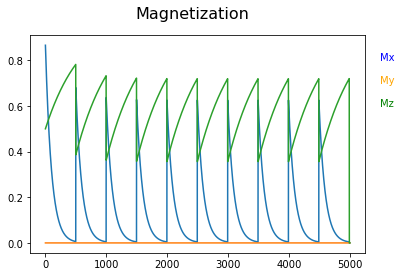

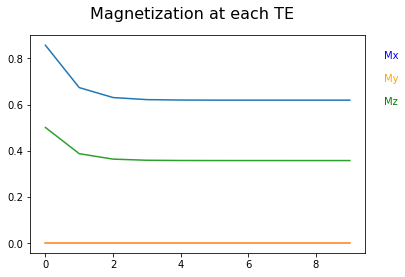

In [5]:
df = 0	# Hz off-resonance.
T1 = 600	# ms.
T2 = 100	# ms.
TE = 1    #ms
TR = 500     #ms
alpha = pi/3      #deg
Nex = 10	# 20 excitations.
dT = 1 # ms

def simuEchoDeGradient(df,alpha,TE,TR,dT,NEX,T1,T2):
    Ntr = round(TR/dT)
    M = np.zeros((3, int(Ntr*Nex))) # store magnetization along the time
    Mte = np.zeros((3, Nex)) # store magnetization for each TE

    At,Bt = freeprecess(dT,T1, T2, df)
    Ate,Bte = freeprecess(TE,T1, T2, df)

    Rflip = yrot(alpha)
    # initiliaze aimantation along z
    M[:,0] = np.array([0,0,1])

    Mcount=0
    for n in range(0,Nex):
        M[:,Mcount] = Rflip @ M[:,Mcount]
        Mte[:,n] = Ate @ M[:,Mcount] + Bte[:,0]

        for k in range(0,Ntr-1):
            Mcount = Mcount + 1
            M[:,Mcount] = At @ M[:,Mcount-1] + Bt[:,0]

    return M, Mte

############# PLOT
M, Mte = simuEchoDeGradient(df,alpha,TE,TR,dT,Nex,T1,T2)

 # Plot of Mz for    

plot1 = plt.figure(1)
plt.suptitle('Magnetization', fontsize=16)
t = np.arange(0, M.shape[1] , dT)
xpos = M.shape[1]+500
plt.plot(t,M[0,:])
plt.text(xpos, 0.8, 'Mx', horizontalalignment='left', color='blue')
plt.plot(t,M[1,:])
plt.text(xpos, 0.7, 'My', horizontalalignment='left', color='orange')
plt.plot(t,M[2,:])
plt.text(xpos, 0.6, 'Mz', horizontalalignment='left', color='green');


plot1 = plt.figure(2)
plt.suptitle('Magnetization at each TE', fontsize=16)
t = np.arange(0, Mte.shape[1] , 1)
xpos = Mte.shape[1]
plt.plot(t,Mte[0,:])
plt.text(xpos, 0.8, 'Mx', horizontalalignment='left', color='blue')
plt.plot(t,Mte[1,:])
plt.text(xpos, 0.7, 'My', horizontalalignment='left', color='orange')
plt.plot(t,Mte[2,:])
plt.text(xpos, 0.6, 'Mz', horizontalalignment='left', color='green');

In [6]:
# find when M(TE) is stable (<1%)

for n in range(1,Mte.shape[1]):
    if np.abs(Mte[0,n] - Mte[0,n-1])/Mte[0,Mte.shape[1]-1] < 0.01 :
        break
md("The signal reach the steady states (< 1%) after {} excitations".format(n))

The signal reach the steady states (< 1%) after 4 excitations

* Calculez la valeur exact de l'état d'équilibre au TR puis au TE. Ecrivez une fonction **[Msig,Mss]=sssignal(flip,T1,T2,TE,TR,dfreq) ** permettant de calculer le signal de steady-state au TE (Mss) et juste la valeur complexe dans le plan : $$Msig = Mss(1)+i*Mss(2)$$

In [7]:
# A x Rz = Rz x A so
# M1 = Atr * Rflip * M + Btr.
#
# But M1=M in steady state, so
#
# 	Mss = Atr*Rflip * Mss + Btr.
#	(I-Atr*Rflip)*Mss = Btr.
#   (I-Atr*Rflip)^(-1)*(I-Atr*Rflip)*Mss = (I-Atr*Rflip)^(-1) * Btr 
#   Mss = (I-Atr*Rflip)^(-1) * Btr 

df = 0;		# Hz off-resonance.
T1 = 600;	# ms.
T2 = 100;	# ms.
TE = 1;		# ms.
TR = 500;	# ms.
flip = pi/3;	# radians.

Rflip = yrot(flip)
Atr,Btr = freeprecess(TR,T1,T2,df)
Mss = np.linalg.inv(np.eye(3)-Atr @ Rflip) @ Btr
display(md('The steady state at TR is equal to Mx = {} My = {} Mz = {}'.format(Mss[0],Mss[1],Mss[2])))
# Maintenant on va calculer avec le TE
Ate,Bte = freeprecess(TE,T1,T2,df)
MssTE = Ate @ Rflip @ Mss + Bte
display(md('The steady state at TE is equal to : {}'.format(MssTE[0])))

def sssignal(flip,T1,T2,TE,TR,df):
    # Steady-state directement au TE

    # 	Starting at TE, M=M1
    #	At TR, M=M2, and M2=Atetr*M1+Btetr.
    # 	At TE, M=M3, and M3=Ate*Rflip*M2+Bte.
    #			M3=Ate*Rflip*(Atetr*M1+Btetr)+Bte.
    #	But M3=M1=Mss at steady state:
    #   (I - Ate*Rflip*Atetr) * Mss = Ate Rflip Btetr + Bte
    Atr,Btr = freeprecess(TR,T1,T2,df)
    Ate,Bte = freeprecess(TE,T1,T2,df)
    Atetr,Btetr = freeprecess(TR-TE,T1,T2,df)

    Mss = np.linalg.inv(np.eye(3)-Ate @ Rflip @ Atetr) @ (Ate @ Rflip @ Btetr + Bte)
    Msig = complex(Mss[0],Mss[1])

    return Msig, Mss

[Msig,Mss] = sssignal(flip,T1,T2,TE,TR,df)
display(md('The steady state at TE with function is equal to : {}'.format(Msig)))

The steady state at TR is equal to Mx = [0.00421759] My = [0.] Mz = [0.72034465]

The steady state at TE is equal to : [0.6197173]

The steady state at TE with function is equal to : (0.6197173002579988+0j)

Dans le cas d'une séquence **FLASH** (**F**ast **L**ow **A**ngle **SH**ot) l'aimantation steady-state longitudinal (selon l'axe z) est égale à $$M_{ss}= \frac{M_0(1-E_1)}{1-E_1 \cos \theta} = 0.7224$$ . Cette différence s'explique par le fait que l'aimantation est spoilée à la fin de chaque TR (RF et phase spoiling) donc que l'aimantation transversale (selon x/y) est égale à 0.

* Implémentez le *spoiling idéal* et vérifiez que la valeur correspond à l'équation analytique ci-dessus

In [8]:
# Let's spoil at the end of TR
spoiler = [[0,0,0],[0,0,0],[0,0,1]]

Rflip = yrot(flip)
Atr,Btr = freeprecess(TR,T1,T2,df)
Mss = np.linalg.inv(np.eye(3)- spoiler @ Atr @ Rflip) @ Btr
display(md('The steady state at TR is equal to Mx = {} My = {} Mz = {}'.format(Mss[0],Mss[1],Mss[2])))

The steady state at TR is equal to Mx = [0.] My = [0.] Mz = [0.72237274]

## 4. Spin echo
<h5><u>Simulation</u></h5>


![Spin_Echo](img/Spin_Echo.png)

* Simuler le signal au cours d'un TR et affichez l'aimantation Mx, My et Mz. 

```T1 = 600 ms
T1 = 600  ms
T2 = 100  ms
df = 10   Hz
TR = 500  ms
TE = 50   ms
dT = 1    ms 
```


(3, 500)

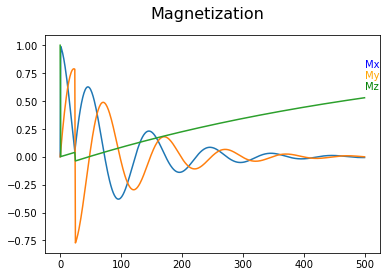

In [9]:
## Simulation Echo de spin sur un TR
dT = 1;		# 1ms delta-time.
T = 1000;	# total duration
df = 10;	# Hz off-resonance.
T1 = 600;	# ms.
T2 = 100;	# ms.
TE = 50;	# ms.
TR = 500;	# ms.

N1 = round(TE/2/dT)
N2 = round((TR-TE/2)/dT)

[A,B] = freeprecess(dT,T1,T2,df)
M = np.zeros((3, int(N1+N2)))
display(M.shape)
M[:,0]=[0,0,1]

Rflip = yrot(pi/2)
Rrefoc = xrot(pi)

M[:,1]= A @ Rflip @ M[:,0] + B[:,0]

for k in range(2, N1):
    M[:,k] = A @ M[:,k-1]+B[:,0]

M[:,N1]= A @ Rrefoc @ M[:,N1-1] + B[:,0]    

for k in range(0, N2-1):
    M[:,k + N1 + 1] = A @ M[:,k + N1]+B[:,0]

## Pot pat
plot1 = plt.figure(1)
plt.suptitle('Magnetization', fontsize=16)
t = np.arange(0, M.shape[1] , dT)
xpos = M.shape[1]
plt.plot(t,M[0,:])
plt.text(xpos, 0.8, 'Mx', horizontalalignment='left', color='blue')
plt.plot(t,M[1,:])
plt.text(xpos, 0.7, 'My', horizontalalignment='left', color='orange')
plt.plot(t,M[2,:])
plt.text(xpos, 0.6, 'Mz', horizontalalignment='left', color='green');


* Qu'observez vous au temps TE ? Comment être sur que c'est bien un écho de spin ?

Pour cela -> Simulez 5 isochromates avec des valeurs différentes d'off-resonance (df) puis affichez  sur le même graphique: La valeur absolue d'un isochromate dans le plan transverse ($M_{Sig}=\sqrt{x^2+y^2}$) la valeur absolue de la somme des isochromates ainsi que la phase de chaque isochromate


(0.0, 523.95)

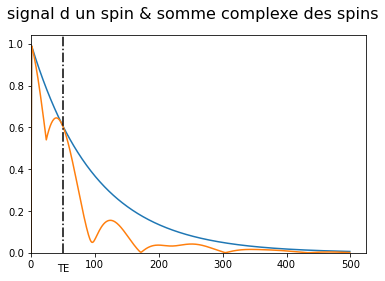

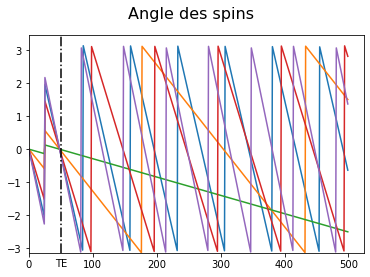

In [10]:
## Simulation Echo de spin sur un TR
dT = 1;		# 1ms delta-time.
T = 1000;	# total duration
T1 = 600;	# ms.
T2 = 100;	# ms.
TE = 50;	# ms.
TR = 500;	# ms.

# Nombre isochromate 
Nf = 5
df = 50 * (np.random.random(Nf)-0.5) # off-resonance de -50 à 50 hz

N1 = round(TE/2/dT)
N2 = round((TR-TE/2)/dT)

Msig = np.zeros((Nf, int(N1+N2)),dtype=complex)
for f in range(0,Nf):
    [A,B] = freeprecess(dT,T1,T2,df[f])
    M = np.zeros((3, int(N1+N2)))
    M[:,0]=[0,0,1]

    Rflip = yrot(pi/2)
    Rrefoc = xrot(pi)

    M[:,1]= A @ Rflip @ M[:,0] + B[:,0]

    for k in range(2, N1):
        M[:,k] = A @ M[:,k-1]+B[:,0]

    M[:,N1]= A @ Rrefoc @ M[:,N1-1] + B[:,0]    

    for k in range(0, N2-1):
        M[:,k + N1 + 1] = A @ M[:,k + N1]+B[:,0]

    Msig[f,:] = M[0,...] + 1j * M[1,...]


# show results

plot1 = plt.figure(1)
plt.suptitle('signal d un spin & somme complexe des spins', fontsize=16)
t = np.arange(0, Msig.shape[1] , dT)
xpos = Msig.shape[1]
plt.plot(t,abs(Msig[1,:]))
plt.plot(t,abs(mean(Msig[:,:],0)))
ax = plt.axes()
ax.set_ylim(bottom=0)
ax.set_xlim(left=0)

plt.axvline(x=TE,color='black',linestyle='-.')
plt.text(TE, -0.1, 'TE', verticalalignment='bottom',horizontalalignment='center', color='black')


plot1 = plt.figure(2)
plt.suptitle('Angle des spins', fontsize=16)
t = np.arange(0, Msig.shape[1] , dT)
xpos = Msig.shape[1]
plt.plot(t,np.angle(Msig.transpose()))
plt.axvline(x=TE,color='black',linestyle='-.')
plt.text(TE, -pi-0.4, 'TE', horizontalalignment='center', color='black');
ax = plt.axes()
ax.set_ylim(bottom=-pi)
ax.set_xlim(left=0)



* Expliquez pourquoi la courbe de la somme (divisée par le nombre d'isochromates) croise la courbe de la valeur absolue.

Refaites la même simulation plusieurs fois pour voir les différences et augmenter le nombre d'isochromates dans la simulation



###  Steady-state

* Calculez le steady state au TE de la séquence Spin-Echo


In [11]:
def sesignal(T1,T2,TE,TR,dfreq):
    Rflip = yrot(pi/2) # Rotation from excitation pulse (90)
    Rrefoc = xrot(pi) # Rotation from refocusing pulse (usually 180)
    [Atr,Btr] = freeprecess(TR-TE,T1,T2,dfreq) # Propagation TE to TR
    [Ate2,Bte2] = freeprecess(TE/2,T1,T2,dfreq) # Propagation 0 to TE/2 (same as TE/2 to TE)

    spoiler = [[0,0,0],[0,0,0],[0,0,1]] # Neglect residual transverse magnetization prior to excitation.
    Atr =  spoiler @ Atr # (Just keep Mz component)

    # Let 	M1 be the magnetization just before the 90.
    #	M2 be just before the 180.
    #	M3 be at TE.
    #	M4 = M1
    #
    # then
    #	M2 = Ate2*Rflip*M1 + Bte2
    #	M3 = Ate2*Rrefoc*M2 + Bte2
    #	M4 = Atr * M3 + Btr
    #
    # Solve for M3... (Magnetization at TE)
    #

    Mss = np.linalg.inv(np.eye(3) - Ate2 @ Rrefoc @ Ate2 @ Rflip @ Atr) @ (Bte2 + Ate2 @ Rrefoc @ (Bte2 + Ate2 @ Rflip @ Btr))

    Msig = complex(Mss[0],Mss[1])
    return Msig, Mss

## 
df = 0	# Hz off-resonance.
T1 = 600	# ms.
T2 = 100	# ms.
TE = 50 # ms.
TR = 1000	# ms.

[Msig,Mss] = sesignal(T1,T2,TE,TR,df)
abs(Msig)

0.4822235671718819

* Etendre ce calcul pour une séquence Turbo-spin echo (Echo Train Lenght = 8) voir présentation pour propagation des équations.

  ![Turbo_Spin_Echo](img/Turbo_Spin_Echo.png)

In [12]:
def fsesignal(T1,T2,TE,TR,dfreq,ETL):
    Rflip = yrot(pi/2) # Rotation from excitation pulse (90)
    Rrefoc = xrot(pi) # Rotation from refocusing pulse (usually 180)
    [Atr,Btr] = freeprecess(TR-ETL*TE,T1,T2,dfreq) # Propagation TE to TR
    [Ate2,Bte2] = freeprecess(TE/2,T1,T2,dfreq) # Propagation 0 to TE/2 (same as TE/2 to TE)

    spoiler = [[0,0,0],[0,0,0],[0,0,1]] # Neglect residual transverse magnetization prior to excitation.
    Atr =  spoiler @ Atr # (Just keep Mz component)

    # Since ETL varies, let's keep a "running" A and B.  We'll
    # calculate the steady-state signal just after the tip, Rflip.

    A = np.eye(3)
    B = np.zeros((3,1))

    # For each echo, we "propagate" A and B:
    for k in range(0,ETL):
        A = Ate2 @ Rrefoc @ Ate2 @ A # TE/2--Refoc--TE/2
        B = Bte2 + Ate2 @ Rrefoc @ (Bte2 + Ate2 @ B)
        
    
    # Propagate A and B through to just after flip, and calculate steady-state.
    A = Rflip @ Atr @ A
    B = Rflip @ (Btr + Atr @ B)

    Mss = np.linalg.inv(np.eye(3)-A) @ B
    
    # Calculate signal on each echo
    M = Mss
    Msig = np.zeros((ETL, 1),dtype=complex)

    for k in range(0,ETL):
        M = Ate2 @ Rrefoc @ Ate2 @ M + Bte2 + Ate2 @ Rrefoc @ Bte2
        Msig[k] = complex(M[0],M[1])

    return Msig, Mss

## 
df = 0	# Hz off-resonance.
T1 = 600	# ms.
T2 = 100	# ms.
TE = 50 # ms.
TR = 1000	# ms.
ETL = 8

[Msig,Mss] = fsesignal(T1,T2,TE,TR,df,ETL)
abs(Msig)

array([[0.38349468],
       [0.23260128],
       [0.14107981],
       [0.08556923],
       [0.05190036],
       [0.03147916],
       [0.01909308],
       [0.01158054]])

* Calculez le steady-state au 1er TE et comparez avec le steady-state de la séquence Spin-Echo. Vérifiez la valeur en mettant un Echo Train Length = 1. Expliquez ce résultat.

  

In [13]:

ETL = 1
[Msig,Mss] = fsesignal(T1,T2,TE,TR,df,ETL)

ETL = 8
[Msig2,Mss2] = fsesignal(T1,T2,TE,TR,df,ETL)

display(md('The steady state at TE for ETL 1  = {} and for ETL 8 = {}'.format(abs(Msig[0]),abs(Msig2[0]))))

The steady state at TE for ETL 1  = [0.48222357] and for ETL 8 = [0.38349468]

<h3>OPTIONAL : BSSFP et banding artefacts</h3>

BSSFP est l'acronyme pour "Balanced Steady-State Free Precession". C'est une dans laquelle les gradients sont équilibré (dont la somme au cours du TR = 0)

<img src="img/bssfp_sequence.png" alt="bssfp_sequence" style="zoom: 50%;" /><img src="../../TP/img/bssfp.png" alt="bssfp" style="zoom:50%;" />

Cette séquence est donc équivalente à la séquence d'écho de gradient simulé dans la partie 3. Elle a pour particularité d'avoir un fort signal qui est un compromis T1/T2 avec des TRs court ainsi que de généré des **artéfacts de bande noire**.

Pour le simuler il faut prendre un compte l'off-resonance qui peut exister dans un voxel. 

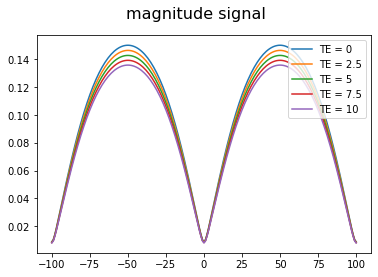

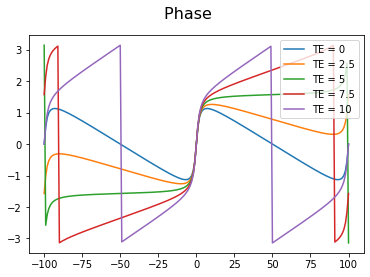

In [14]:


def sssignal(flip,T1,T2,TE,TR,df):
    # Steady-state directement au TE

    # 	Starting at TE, M=M1
    #	At TR, M=M2, and M2=Atetr*M1+Btetr.
    # 	At TE, M=M3, and M3=Ate*Rflip*M2+Bte.
    #			M3=Ate*Rflip*(Atetr*M1+Btetr)+Bte.
    #	But M3=M1=Mss at steady state:
    #   (I - Ate*Rflip*Atetr) * Mss = Ate Rflip Btetr + Bte
    
    Atr,Btr = freeprecess(TR,T1,T2,df)
    Ate,Bte = freeprecess(TE,T1,T2,df)
    Atetr,Btetr = freeprecess(TR-TE,T1,T2,df)

    Mss = np.linalg.inv(np.eye(3)-Ate @ Rflip @ Atetr) @ (Ate @ Rflip @ Btetr + Bte)
    Msig = complex(Mss[0],Mss[1])

    return Msig, Mss

T1 = 600	
T2 = 100	
TE = [0,2.5,5,7.5,10]
TR = 10
flip = pi/3
df = range(-100,101,1)

a=shape(TE)
b=shape(df)


M = np.zeros((b[0],a[0]),dtype=complex)

i = 0
for T in TE:
    k=0
    for freq in df:
        [Msig,Mss] = sssignal(flip,T1,T2,T,TR,freq)
        M[k,i] = Msig
        k = k + 1
    i = i + 1


# show results
labels = ['TE = 0', 'TE = 2.5', 'TE = 5', 'TE = 7.5','TE = 10']

plot1 = plt.figure(1)
plt.suptitle('magnitude signal ', fontsize=16)
xpos = M.shape[0]
for k in range(0,M.shape[1]):
    plt.plot(df,abs(M[:,k]),label=labels[k])

plt.legend(loc='upper right')   


plot1 = plt.figure(2)

plt.suptitle('Phase ', fontsize=16)
xpos = M.shape[0]
plt.plot(df,np.angle(M))
plt.legend(labels,loc=1);




In [15]:
def sssignal(flip,T1,T2,TE,TR,df):
    # Steady-state directement au TE

    # 	Starting at TE, M=M1
    #	At TR, M=M2, and M2=Atetr*M1+Btetr.
    # 	At TE, M=M3, and M3=Ate*Rflip*M2+Bte.
    #			M3=Ate*Rflip*(Atetr*M1+Btetr)+Bte.
    #	But M3=M1=Mss at steady state:
    #   (I - Ate*Rflip*Atetr) * Mss = Ate Rflip Btetr + Bte
    
    Atr,Btr = freeprecess(TR,T1,T2,df)
    Ate,Bte = freeprecess(TE,T1,T2,df)
    Atetr,Btetr = freeprecess(TR-TE,T1,T2,df)

    Mss = np.linalg.inv(np.eye(3)-Ate @ Rflip @ Atetr) @ (Ate @ Rflip @ Btetr + Bte)
    Msig = complex(Mss[0],Mss[1])

    return Msig, Mss

def plotSimu(TR):
    T1 = 600	
    T2 = 100	
    TE = TR/2
    flip = pi/3
    df = range(-200,201,1)
    print(TE)

    b=shape(df)


    M = np.zeros(b[0],dtype=complex)

    k=0
    for freq in df:
        [Msig,Mss] = sssignal(flip,T1,T2,TE,TR,freq)
        M[k] = Msig
        k = k + 1

    # show results
 
    fig, (plot1,plot2) = plt.subplots(1,2)
    plot1.set_title('magnitude signal ', fontsize=16)
    plot1.plot(df,abs(M))


    plot2.set_title('Phase ', fontsize=16)
    xpos = M.shape[0]
    plot2.plot(df,np.angle(M))



widgets.interact(plotSimu, TR=(2, 20, 1));

interactive(children=(IntSlider(value=11, description='TR', max=20, min=2), Output()), _dom_classes=('widget-i…